#**Setup**

In [ ]:
%%capture
!git clone https://github.com/AI4Bharat/IndicTrans2.git

In [ ]:
%%capture
%cd /content/IndicTrans2/huggingface_interface

In [ ]:
%%capture
!python3 -m pip install nltk sacremoses pandas regex mock transformers>=4.33.2 mosestokenizer
!python3 -c "import nltk; nltk.download('punkt')"
!python3 -m pip install bitsandbytes scipy accelerate datasets
!python3 -m pip install sentencepiece

!git clone https://github.com/VarunGumma/IndicTransToolkit.git
%cd IndicTransToolkit
!python3 -m pip install --editable ./
%cd ..

**---Restart the Runtime**

#**Interference**

In [ ]:
import torch
from transformers import AutoModelForSeq2SeqLM, BitsAndBytesConfig, AutoTokenizer
from IndicTransToolkit import IndicProcessor

BATCH_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
quantization = None

In [ ]:
def initialize_model_and_tokenizer(ckpt_dir, quantization):
    if quantization == "4-bit":
        qconfig = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )
    elif quantization == "8-bit":
        qconfig = BitsAndBytesConfig(
            load_in_8bit=True,
            bnb_8bit_use_double_quant=True,
            bnb_8bit_compute_dtype=torch.bfloat16,
        )
    else:
        qconfig = None

    tokenizer = AutoTokenizer.from_pretrained(ckpt_dir, trust_remote_code=True)
    model = AutoModelForSeq2SeqLM.from_pretrained(
        ckpt_dir,
        trust_remote_code=True,
        low_cpu_mem_usage=True,
        quantization_config=qconfig,
    )

    if qconfig == None:
        model = model.to(DEVICE)
        if DEVICE == "cuda":
            model.half()

    model.eval()

    return tokenizer, model


def batch_translate(input_sentences, src_lang, tgt_lang, model, tokenizer, ip):
    translations = []
    for i in range(0, len(input_sentences), BATCH_SIZE):
        batch = input_sentences[i : i + BATCH_SIZE]

        # Preprocess the batch and extract entity mappings
        batch = ip.preprocess_batch(batch, src_lang=src_lang, tgt_lang=tgt_lang)

        # Tokenize the batch and generate input encodings
        inputs = tokenizer(
            batch,
            truncation=True,
            padding="longest",
            return_tensors="pt",
            return_attention_mask=True,
        ).to(DEVICE)

        # Generate translations using the model
        with torch.no_grad():
            generated_tokens = model.generate(
                **inputs,
                use_cache=True,
                min_length=0,
                max_length=256,
                num_beams=5,
                num_return_sequences=1,
            )

        # Decode the generated tokens into text

        with tokenizer.as_target_tokenizer():
            generated_tokens = tokenizer.batch_decode(
                generated_tokens.detach().cpu().tolist(),
                skip_special_tokens=True,
                clean_up_tokenization_spaces=True,
            )

        # Postprocess the translations, including entity replacement
        translations += ip.postprocess_batch(generated_tokens, lang=tgt_lang)

        del inputs
        torch.cuda.empty_cache()

    return translations

# **Speech to Text**

In [ ]:
!pip install openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 52.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-2.2.5:
      Successfully uninstalled numpy-2.2.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
indic-nlp-library-itt 0.1.0 requires numpy<3.0.0,>=2.2.5, but you have numpy 2.0.2 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [ ]:
!pip uninstall -y numpy numba


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: numba 0.59.0
Uninstalling numba-0.59.0:
  Successfully uninstalled numba-0.59.0


In [ ]:
!pip install numpy


  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
openai-whisper 20240930 requires numba, which is not installed.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, which is not installed.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, which is not installed.
librosa 0.11.0 requires numba>=0.51.0, which is not installed.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, which is not installed.
umap-learn 0.5.7 requires numba>=0.51.2, which is not installed.
distributed-ucxx-cu12 0.42.0 requires numba<0.61.0a0,>=0.59.1, which is not installed.
pynndescent 0.5.13 requires numba>=0.51.2, which is not installed.
shap 0.47.2 requires numba>=0.54, which is not installed.

In [ ]:
!pip install numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 27.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 14.2 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.42.0
    Uninstalling llvmlite-0.42.0:
      Successfully uninstalled llvmlite-0.42.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cuda 25.2.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cudf-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
cuml-cu12 25.2.1 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.
distributed-ucxx-cu12 0.42.0 requires numba<0.61.0a0,>=0.59.1, but you have numba 0.61.2 which is incompatible.


**Amplifying Audio**

In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment
import os

def amplify_audio(input_path, output_path, target_dBFS=-20.0):
    audio = AudioSegment.from_file(input_path)
    change_in_dBFS = target_dBFS - audio.dBFS
    amplified_audio = audio.apply_gain(change_in_dBFS)
    amplified_audio.export(output_path, format="wav")

    # Example paths
original_audio = "/content/telugu_audio_input2.wav"
amplified_audio = "/content/tel_output.wav"

amplify_audio(original_audio, amplified_audio)

#**English**

**English to Telugu**

In [ ]:
import whisper
from scipy.io.wavfile import read

# Function to manually input the file location and return transcribed text with quotes
def transcribe_audio(file_location):
    # Load the Whisper model
    model = whisper.load_model("base")

    # Transcribe the manually selected audio file
    result = model.transcribe(file_location)
    transcribed_text = result["text"]

    # Add quotes around the transcribed text
    transcribed_text_with_quotes = f'"{transcribed_text}"'

    return transcribed_text_with_quotes

# Prompt the user to input the file location
file_location = input("Please provide the full path to the audio file: ")

# Call the function and store the result
transcribed_text_with_quotes = transcribe_audio(file_location)

# Print the transcribed text
print("Transcribed Text:", transcribed_text_with_quotes)

# Now, you can use the transcribed text for translation
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

en_sents = [transcribed_text_with_quotes]

src_lang, tgt_lang = "eng_Latn", "tel_Telu"
hi_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(en_sents, hi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model


Please provide the full path to the audio file: /content/english_audio_input1.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed Text: " and I would do it again."


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

tokenization_indictrans.py:   0%|          | 0.00/8.04k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- tokenization_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


dict.SRC.json:   0%|          | 0.00/645k [00:00<?, ?B/s]

dict.TGT.json:   0%|          | 0.00/3.39M [00:00<?, ?B/s]

model.SRC:   0%|          | 0.00/759k [00:00<?, ?B/s]

model.TGT:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

configuration_indictrans.py:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_indictrans.py:   0%|          | 0.00/79.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/4.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]


eng_Latn - tel_Telu
eng_Latn: " and I would do it again."
tel_Telu: "మరియు నేను మళ్ళీ చేస్తాను".


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


**English - Hindi**

In [ ]:
import whisper
from scipy.io.wavfile import read

# Function to manually input the file location and return transcribed text with quotes
def transcribe_audio(file_location):
    # Load the Whisper model
    model = whisper.load_model("base")

    # Transcribe the manually selected audio file
    result = model.transcribe(file_location)
    transcribed_text = result["text"]

    # Add quotes around the transcribed text
    transcribed_text_with_quotes = f'"{transcribed_text}"'

    return transcribed_text_with_quotes

# Prompt the user to input the file location
file_location = input("Please provide the full path to the audio file: ")

# Call the function and store the result
transcribed_text_with_quotes = transcribe_audio(file_location)

# Print the transcribed text
print("Transcribed Text:", transcribed_text_with_quotes)

# Now, you can use the transcribed text for translation
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

en_sents = [transcribed_text_with_quotes]

src_lang, tgt_lang = "eng_Latn", "hin_Deva"
hi_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(en_sents, hi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model


Please provide the full path to the audio file: /content/eng_output.wav


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed Text: " and I would do it again."

eng_Latn - hin_Deva
eng_Latn: " and I would do it again."
hin_Deva: "और मैं इसे फिर से करूँगा।"


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#**Hindi**

**Hindi-English**

In [ ]:
import whisper
from scipy.io.wavfile import read

# Function to manually input the file location and return transcribed text with quotes
def transcribe_audio(file_location):
    # Load the Whisper model
    model = whisper.load_model("base")

    # Transcribe the manually selected audio file
    result = model.transcribe(file_location, language="hi")
    transcribed_text = result["text"]

    # Add quotes around the transcribed text
    transcribed_text_with_quotes = f'"{transcribed_text}"'

    return transcribed_text_with_quotes

# Prompt the user to input the file location
file_location = input("Please provide the full path to the audio file: ")

# Call the function and store the result
transcribed_text_with_quotes = transcribe_audio(file_location)

# Print the transcribed text
print("Transcribed Text:", transcribed_text_with_quotes)

# Now, you can use the transcribed text for translation

indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)


en_sents = [transcribed_text_with_quotes]

src_lang, tgt_lang = "hin_Deva", "eng_Latn"
hi_translations = batch_translate(en_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(en_sents, hi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model


Please provide the full path to the audio file: /content/hi-IN-MadhurNeural.mp3


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed Text: " میں جانتا ہوں کہ تمہیں بھوک لگی ہے کیا تم کچھ کھانا چاہوں گے"

hin_Deva - eng_Latn
hin_Deva: " میں جانتا ہوں کہ تمہیں بھوک لگی ہے کیا تم کچھ کھانا چاہوں گے"
eng_Latn: "I know you're hungry, would you like something to eat?"


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


**Hindi-Telugu**

In [ ]:
import whisper
from scipy.io.wavfile import read

# Function to manually input the file location and return transcribed text with quotes
def transcribe_audio(file_location):
    # Load the Whisper model
    model = whisper.load_model("base")

    # Transcribe the manually selected audio file
    result = model.transcribe(file_location, language="hi")
    transcribed_text = result["text"]

    # Add quotes around the transcribed text
    transcribed_text_with_quotes = f'"{transcribed_text}"'

    return transcribed_text_with_quotes

# Prompt the user to input the file location
file_location = input("Please provide the full path to the audio file: ")

# Call the function and store the result
transcribed_text_with_quotes = transcribe_audio(file_location)

# Print the transcribed text
print("Transcribed Text:", transcribed_text_with_quotes)

# Now, you can use the transcribed text for translation

indic_indic_ckpt_dir = "ai4bharat/indictrans2-indic-indic-1B"  # ai4bharat/indictrans2-indic-indic-dist-320M
indic_indic_tokenizer, indic_indic_model = initialize_model_and_tokenizer(indic_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)


en_sents = [transcribed_text_with_quotes]

src_lang, tgt_lang = "hin_Deva", "tel_Telu"
hi_translations = batch_translate(en_sents, src_lang, tgt_lang, indic_indic_model, indic_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(en_sents, hi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_indic_tokenizer, indic_indic_model


Please provide the full path to the audio file: /content/drive/MyDrive/नमस्ते सर आप कहां जा.m4a


/usr/local/lib/python3.11/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=device)
/usr/local/li

Transcribed Text: " νமستے Sir, آپ کہاں جا رہی ہیں ?"

hin_Deva - tel_Telu
hin_Deva: " νமستے Sir, آپ کہاں جا رہی ہیں ?"
tel_Telu: "మీరు ఎక్కడికి వెళుతున్నారు, సర్?" 


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


#**Telugu**

**Telugu Transcription**

In [ ]:
import soundfile as sf
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa

def parse_transcription(wav_file):
    # Load pretrained model
    processor = Wav2Vec2Processor.from_pretrained("addy88/wav2vec2-telugu-stt")
    model = Wav2Vec2ForCTC.from_pretrained("addy88/wav2vec2-telugu-stt")

    # Load and resample audio to 16 kHz
    audio_input, sample_rate = sf.read(wav_file)
    audio_input = librosa.resample(audio_input, orig_sr=sample_rate, target_sr=16000)  # Resample to 16 kHz
    sample_rate = 16000  # Update the sample rate to 16000

    # Pad input values and return pt tensor
    input_values = processor(audio_input, sampling_rate=sample_rate, return_tensors="pt").input_values

    # Inference: retrieve logits & take argmax
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # Transcribe
    transcription = processor.decode(predicted_ids[0], skip_special_tokens=True)
    print(transcription)

# Call the function with the path to the file
parse_transcription("/content/drive/MyDrive/tef_01033_00007107192.wav")


preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

అనగా మన దేశానికి హిందీ అధికార భాష


In [ ]:
import soundfile as sf
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa

def parse_transcription(wav_file):
    # Load pretrained model
    processor = Wav2Vec2Processor.from_pretrained("addy88/wav2vec2-telugu-stt")
    model = Wav2Vec2ForCTC.from_pretrained("addy88/wav2vec2-telugu-stt")

    # Load and resample audio to 16 kHz
    audio_input, sample_rate = sf.read(wav_file)
    audio_input = librosa.resample(audio_input, orig_sr=sample_rate, target_sr=16000)  # Resample to 16 kHz
    sample_rate = 16000  # Update the sample rate to 16000

    # Pad input values and return pt tensor
    input_values = processor(audio_input, sampling_rate=sample_rate, return_tensors="pt").input_values

    # Inference: retrieve logits & take argmax
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # Transcribe
    transcription = processor.decode(predicted_ids[0], skip_special_tokens=True)
    return transcription

# Get transcription from the audio file
transcription = parse_transcription("/content/drive/MyDrive/tef_01033_00007107192.wav")
print(f"Transcription: {transcription}")

# Now proceed with the translation step

indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [transcription]
src_lang, tgt_lang = "tel_Telu", "eng_Latn"
en_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)


print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, en_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model


Transcription: అనగా మన దేశానికి హిందీ అధికార భాష

tel_Telu - eng_Latn
tel_Telu: అనగా మన దేశానికి హిందీ అధికార భాష
eng_Latn: Hindi is the official language of our country.


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


**Telugu-Hindi**

In [ ]:
import soundfile as sf
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import librosa

def parse_transcription(wav_file):
    # Load pretrained model
    processor = Wav2Vec2Processor.from_pretrained("addy88/wav2vec2-telugu-stt")
    model = Wav2Vec2ForCTC.from_pretrained("addy88/wav2vec2-telugu-stt")

    # Load and resample audio to 16 kHz
    audio_input, sample_rate = sf.read(wav_file)
    audio_input = librosa.resample(audio_input, orig_sr=sample_rate, target_sr=16000)  # Resample to 16 kHz
    sample_rate = 16000  # Update the sample rate to 16000

    # Pad input values and return pt tensor
    input_values = processor(audio_input, sampling_rate=sample_rate, return_tensors="pt").input_values

    # Inference: retrieve logits & take argmax
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # Transcribe
    transcription = processor.decode(predicted_ids[0], skip_special_tokens=True)
    return transcription

# Get transcription from the audio file
transcription = parse_transcription("/content/drive/MyDrive/tef_01033_00007107192.wav")
print(f"Transcription: {transcription}")

# Now proceed with the translation step

indic_indic_ckpt_dir = "ai4bharat/indictrans2-indic-indic-1B"  # ai4bharat/indictrans2-indic-indic-dist-320M
indic_indic_tokenizer, indic_indic_model = initialize_model_and_tokenizer(indic_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [transcription]
src_lang, tgt_lang = "tel_Telu", "hin_Deva"
mr_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_indic_model, indic_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, mr_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_indic_tokenizer, indic_indic_model

Transcription: అనగా మన దేశానికి హిందీ అధికార భాష

tel_Telu - hin_Deva
tel_Telu: అనగా మన దేశానికి హిందీ అధికార భాష
hin_Deva: इसका मतलब है कि हिंदी हमारे देश की आधिकारिक भाषा है। 


# **Text to Text**

#**English**

**English to Telugu**

In [ ]:
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

en_sents = [
   "I would like to formally invite you to our esteemed event"
]

src_lang, tgt_lang = "eng_Latn", "tel_Telu"
hi_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(en_sents, hi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model


eng_Latn - tel_Telu
eng_Latn: I would like to formally invite you to our esteemed event
tel_Telu: మా గౌరవనీయమైన కార్యక్రమానికి మిమ్మల్ని అధికారికంగా ఆహ్వానించాలనుకుంటున్నాను.


**English-Hindi**

In [ ]:
en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

en_sents = [
    "Bindu Madhuri is an introvert"
]

src_lang, tgt_lang = "eng_Latn", "hin_Deva"
hi_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(en_sents, hi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model


eng_Latn - hin_Deva
eng_Latn: Bindu Madhuri is an introvert
hin_Deva: बिंदु माधुरी एक अंतर्मुखी हैं।


#**Hindi**

**Hindi - English**

In [ ]:
indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [
    "मैं पागल थी और मेरा नाम बिंदु माधुरी है।",
]
src_lang, tgt_lang = "hin_Deva", "eng_Latn"
en_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)


print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, en_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model


hin_Deva - eng_Latn
hin_Deva: मैं पागल थी और मेरा नाम बिंदु माधुरी है।
eng_Latn: I was crazy and my name is Bindu Madhuri.


**Hindi - Telugu**

In [ ]:
indic_indic_ckpt_dir = "ai4bharat/indictrans2-indic-indic-1B"  # ai4bharat/indictrans2-indic-indic-dist-320M
indic_indic_tokenizer, indic_indic_model = initialize_model_and_tokenizer(indic_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [
    "मैं एक अच्छी लड़की हूं।"
]
src_lang, tgt_lang = "hin_Deva", "tel_Telu"
mr_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_indic_model, indic_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, mr_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_indic_tokenizer, indic_indic_model


hin_Deva - tel_Telu
hin_Deva: मैं एक अच्छी लड़की हूं।
tel_Telu: నేను మంచి అమ్మాయిని.


#**Telugu**

**Telugu-English**

In [ ]:
indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [
    "నీళ్ళ లో పడితే తడవక తప్పదు"
]
src_lang, tgt_lang = "tel_Telu", "eng_Latn"
en_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)


print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, en_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model


tel_Telu - eng_Latn
tel_Telu: నీళ్ళ లో పడితే తడవక తప్పదు
eng_Latn: If you fall into the water, you should not get wet.


**Telugu-Hindi**

In [ ]:
indic_indic_ckpt_dir = "ai4bharat/indictrans2-indic-indic-1B"  # ai4bharat/indictrans2-indic-indic-dist-320M
indic_indic_tokenizer, indic_indic_model = initialize_model_and_tokenizer(indic_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [
    "మీ పేరు ఏమిటి?"
]
src_lang, tgt_lang = "tel_Telu", "hin_Deva"
mr_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_indic_model, indic_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, mr_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_indic_tokenizer, indic_indic_model


tel_Telu - hin_Deva
tel_Telu: మీ పేరు ఏమిటి?
hin_Deva: आपका नाम क्या है?


# **Text to Speech**

# **English**

**English to hindi**

In [ ]:
#Text-Text Translation

en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

en_sents = [
    "Bindu Madhuri is an introvert"
]

src_lang, tgt_lang = "eng_Latn", "hin_Deva"
hi_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(en_sents, hi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model

translated_output = " ".join(hi_translations)


#Text to Speech conversion

from transformers import VitsModel, AutoTokenizer
import torch

model = VitsModel.from_pretrained("facebook/mms-tts-hin")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-hin")

text = translated_output
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs).waveform

from scipy.io.wavfile import write

# Generate waveform
with torch.no_grad():
    output = model(**inputs).waveform

# Save the waveform as a .wav file
waveform = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to numpy
sample_rate = 16000  # Specify the sample rate, check model documentation if unsure
write("/content/output_audio_hin.wav", sample_rate, waveform)

print("Audio saved as output_audio_hin.wav")





eng_Latn - hin_Deva
eng_Latn: Bindu Madhuri is an introvert
hin_Deva: बिंदु माधुरी एक अंतर्मुखी हैं।
Audio saved as output_audio_hin.wav


**English to Telugu**

In [ ]:
#Text- Text Translation

en_indic_ckpt_dir = "ai4bharat/indictrans2-en-indic-1B"  # ai4bharat/indictrans2-en-indic-dist-200M
en_indic_tokenizer, en_indic_model = initialize_model_and_tokenizer(en_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

en_sents = [
    "Bhargavi, she is a good girl"
]

src_lang, tgt_lang = "eng_Latn", "tel_Telu"
hi_translations = batch_translate(en_sents, src_lang, tgt_lang, en_indic_model, en_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(en_sents, hi_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del en_indic_tokenizer, en_indic_model

translated_output = " ".join(hi_translations)

#Text - Speech Conversion

from transformers import VitsModel, AutoTokenizer
import torch

model = VitsModel.from_pretrained("facebook/mms-tts-tel")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-tel")

text = translated_output
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs).waveform

from scipy.io.wavfile import write

# Generate waveform
with torch.no_grad():
    output = model(**inputs).waveform

# Save the waveform as a .wav file
waveform = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to numpy
sample_rate = 16000  # Specify the sample rate, check model documentation if unsure
write("/content/output_audio_tel.wav", sample_rate, waveform)

print("Audio saved as output_audio_tel.wav")




eng_Latn - tel_Telu
eng_Latn: Bhargavi, she is a good girl
tel_Telu: భార్గవి, ఆమె మంచి అమ్మాయి.
Audio saved as output_audio_tel.wav


#**Hindi**

**Hindi to English**

In [ ]:
#Text-Text translation

indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [
    "मैं पागल थी और मेरा नाम बिंदु माधुरी है।",
]
src_lang, tgt_lang = "hin_Deva", "eng_Latn"
en_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)


print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, en_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model

#print(translation)

#translated_output = " ".join(translation)



#Text - Speech Conversion

from transformers import VitsModel, AutoTokenizer
import torch

model = VitsModel.from_pretrained("facebook/mms-tts-eng")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-eng")

text = translation
print(text)
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs).waveform

from scipy.io.wavfile import write

# Generate waveform
with torch.no_grad():
    output = model(**inputs).waveform

# Save the waveform as a .wav file
waveform = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to numpy
sample_rate = 16000  # Specify the sample rate, check model documentation if unsure
write("/content/output_audio_eng.wav", sample_rate, waveform)

print("Audio saved as output_audio_eng.wav")




hin_Deva - eng_Latn
hin_Deva: मैं पागल थी और मेरा नाम बिंदु माधुरी है।
eng_Latn: I was crazy and my name is Bindu Madhuri.
I was crazy and my name is Bindu Madhuri.
Audio saved as output_audio_eng.wav


**Hindi to Telugu**

In [ ]:
#Text-Text translation

indic_indic_ckpt_dir = "ai4bharat/indictrans2-indic-indic-1B"  # ai4bharat/indictrans2-indic-indic-dist-320M
indic_indic_tokenizer, indic_indic_model = initialize_model_and_tokenizer(indic_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [
    "मैं एक अच्छी लड़की हूं।"
]
src_lang, tgt_lang = "hin_Deva", "tel_Telu"
mr_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_indic_model, indic_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, mr_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_indic_tokenizer, indic_indic_model

#Text - Speech Conversion

from transformers import VitsModel, AutoTokenizer
import torch

model = VitsModel.from_pretrained("facebook/mms-tts-tel")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-tel")

text = translation
print(text)
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs).waveform

from scipy.io.wavfile import write

# Generate waveform
with torch.no_grad():
    output = model(**inputs).waveform

# Save the waveform as a .wav file
waveform = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to numpy
sample_rate = 16000  # Specify the sample rate, check model documentation if unsure
write("/content/output_audio_tel.wav", sample_rate, waveform)

print("Audio saved as output_audio_tel.wav")


hin_Deva - tel_Telu
hin_Deva: मैं एक अच्छी लड़की हूं।
tel_Telu: నేను మంచి అమ్మాయిని.
నేను మంచి అమ్మాయిని.
Audio saved as output_audio_tel.wav


#**Telugu**

**Telugu to English**

In [ ]:
#Text-Text translation

indic_en_ckpt_dir = "ai4bharat/indictrans2-indic-en-1B"  # ai4bharat/indictrans2-indic-en-dist-200M
indic_en_tokenizer, indic_en_model = initialize_model_and_tokenizer(indic_en_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [
    "నాకో విషయం చెప్పు"
]
src_lang, tgt_lang = "tel_Telu", "eng_Latn"
en_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_en_model, indic_en_tokenizer, ip)


print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, en_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_en_tokenizer, indic_en_model

#Text-Speech conversion

from transformers import VitsModel, AutoTokenizer
import torch

model = VitsModel.from_pretrained("facebook/mms-tts-eng")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-eng")

text = translation
print(text)
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs).waveform

from scipy.io.wavfile import write

# Generate waveform
with torch.no_grad():
    output = model(**inputs).waveform

# Save the waveform as a .wav file
waveform = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to numpy
sample_rate = 16000  # Specify the sample rate, check model documentation if unsure
write("/content/output_audio_eng.wav", sample_rate, waveform)

print("Audio saved as output_audio_eng.wav")


tel_Telu - eng_Latn
tel_Telu: నాకో విషయం చెప్పు
eng_Latn: tell me something
tell me something
Audio saved as output_audio_eng.wav


**Telugu to Hindi**

In [ ]:
#Text-Text translation

indic_indic_ckpt_dir = "ai4bharat/indictrans2-indic-indic-1B"  # ai4bharat/indictrans2-indic-indic-dist-320M
indic_indic_tokenizer, indic_indic_model = initialize_model_and_tokenizer(indic_indic_ckpt_dir, quantization)

ip = IndicProcessor(inference=True)

hi_sents = [
    "మీ పేరు ఏమిటి?"
]
src_lang, tgt_lang = "tel_Telu", "hin_Deva"
mr_translations = batch_translate(hi_sents, src_lang, tgt_lang, indic_indic_model, indic_indic_tokenizer, ip)

print(f"\n{src_lang} - {tgt_lang}")
for input_sentence, translation in zip(hi_sents, mr_translations):
    print(f"{src_lang}: {input_sentence}")
    print(f"{tgt_lang}: {translation}")

# flush the models to free the GPU memory
del indic_indic_tokenizer, indic_indic_model

#Text-Speech conversion

from transformers import VitsModel, AutoTokenizer
import torch

model = VitsModel.from_pretrained("facebook/mms-tts-hin")
tokenizer = AutoTokenizer.from_pretrained("facebook/mms-tts-hin")

text = translation
print(text)
inputs = tokenizer(text, return_tensors="pt")

with torch.no_grad():
    output = model(**inputs).waveform

from scipy.io.wavfile import write

# Generate waveform
with torch.no_grad():
    output = model(**inputs).waveform

# Save the waveform as a .wav file
waveform = output.squeeze(0).cpu().numpy()  # Remove batch dimension and move to numpy
sample_rate = 16000  # Specify the sample rate, check model documentation if unsure
write("/content/output_audio_hin.wav", sample_rate, waveform)

print("Audio saved as output_audio_hin.wav")


tel_Telu - hin_Deva
tel_Telu: మీ పేరు ఏమిటి?
hin_Deva: आपका नाम क्या है?
आपका नाम क्या है?
Audio saved as output_audio_hin.wav


# **Evaluation of the model**

In [ ]:
!pip install sacrebleu


In [ ]:
import sacrebleu
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import numpy as np

# Example reference and predicted translations
# Replace these with actual outputs from your model
references = ["మీకు ఇష్టమైన ఆహారం ఏమిటి?", "आपका पसंदीदा भोजन क्या है?", "What is your name?", "హలో సార్, మీరు ఎక్కడికి వెళ్తున్నారు?",
              "Hindi is the official language of our country", "इसका मतलब है कि हिंदी हमारे देश की आधिकारिक भाषा है।",
              "మా గౌరవనీయమైన కార్యక్రమానికి మిమ్మల్ని అధికారికంగా ఆహ్వానించాలనుకుంటున్నాను.", "बिंदु माधुरी एक अंतर्मुखी हैं।",
              "I was crazy and my name is Bindu Madhuri.", "నేను మంచి అమ్మాయిని.", "If you fall into the water, you will get wet.",
              "आपका नाम क्या है?",
]
predictions = ["మీకు ఇష్టమైన ఆహారం ఏమిటి?", "आपका पसंदीदा भोजन क्या है?", "What is your name?", "మీరు ఎక్కడికి వెళుతున్నారు, సర్?",
              "Hindi is the official language of our country", "इसका मतलब है कि हिंदी हमारे देश की आधिकारिक भाषा है।",
              "మా గౌరవనీయమైన కార్యక్రమానికి మిమ్మల్ని అధికారికంగా ఆహ్వానించాలనుకుంటున్నాను.", "बिंदु माधुरी एक अंतर्मुखी हैं।",
              "I was crazy and my name is Bindu Madhuri.", "నేను మంచి అమ్మాయిని.", "If you fall into the water, you should get wet.",
              "आपका नाम क्या है?",
]



**BLEU Score**

In [ ]:
bleu = sacrebleu.corpus_bleu(predictions, [references])
print(f"BLEU Score: {bleu.score}")

BLEU Score: 88.96214482868012


**Accuracy**

In [ ]:
accuracy = accuracy_score(references, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 83.33%


**Confusion Matrix**

In [ ]:
unique_labels = list(set(references + predictions))
reference_indices = [unique_labels.index(ref) for ref in references]
prediction_indices = [unique_labels.index(pred) for pred in predictions]

conf_matrix = confusion_matrix(reference_indices, prediction_indices)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3129 (\N{TELUGU LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3122 (\N{TELUGU LETTER LA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3147 (\N{TELUGU VOWEL SIGN OO}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3128 (\N{TELUGU LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 3134 (\N{TELUGU VOWEL SIGN AA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.11/dist-pa

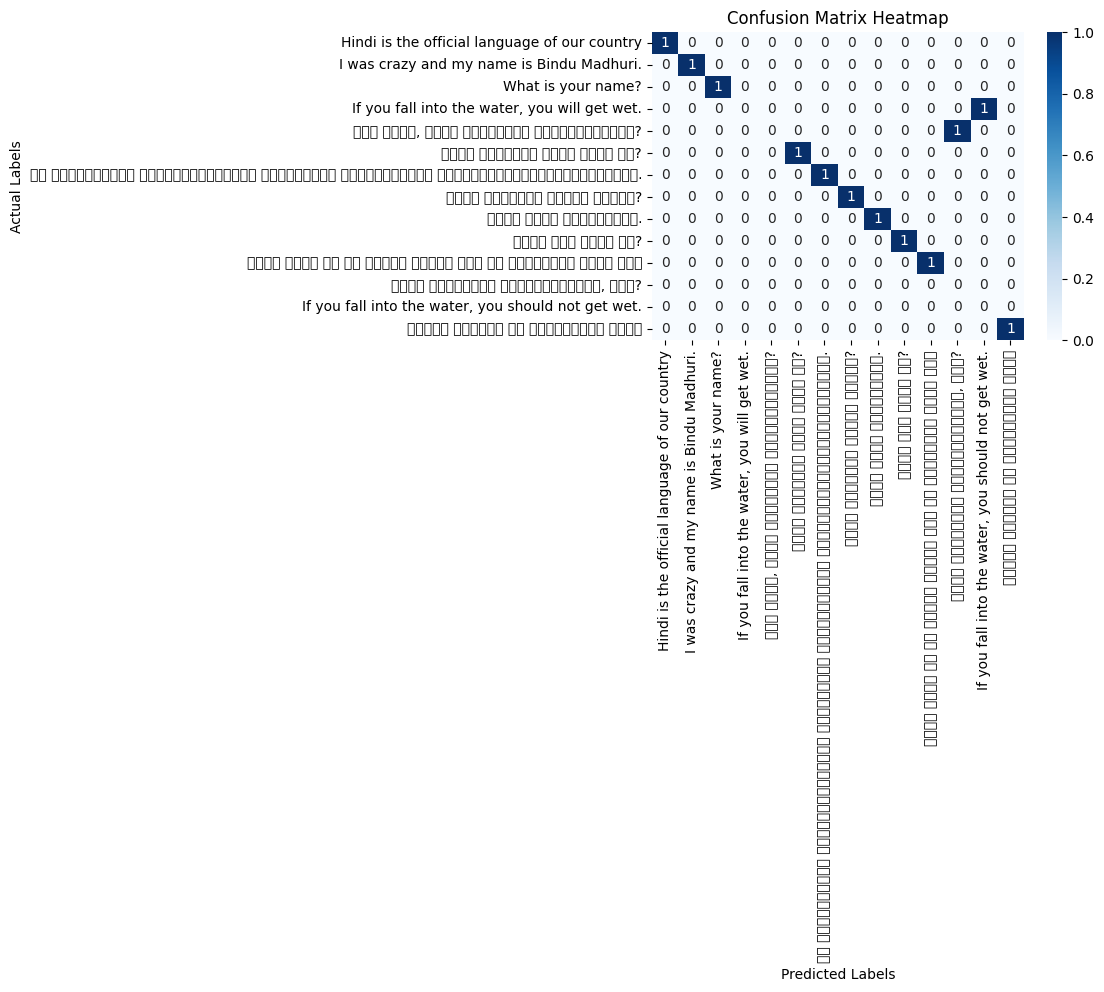

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
conf_matrix = confusion_matrix(reference_indices, prediction_indices)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)

# Labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix Heatmap")

# Show the plot
plt.show()


**F1 Score**

In [ ]:
f1 = f1_score(reference_indices, prediction_indices, average='weighted')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.83


# **Web Interface**

In [ ]:
!pip install gradio transformers datasets torch TTS


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 31.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 27.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 8.3 MB/s 

In [ ]:
import gradio as gr
import torch
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, WhisperProcessor, WhisperForConditionalGeneration
import librosa
import soundfile as sf

# Load ASR (Whisper)
asr_model_name = "openai/whisper-small"
asr_processor = WhisperProcessor.from_pretrained(asr_model_name)
asr_model = WhisperForConditionalGeneration.from_pretrained(asr_model_name)

# Load IndicTrans2 Translation Model
trans_model_name = "ai4bharat/indictrans2-en-indic-1B"
tokenizer = AutoTokenizer.from_pretrained(trans_model_name, trust_remote_code=True)
model = AutoModelForSeq2SeqLM.from_pretrained(trans_model_name, trust_remote_code=True)

# Function to transcribe audio using Whisper
def transcribe_audio(audio_path):
    try:
        audio, sr = librosa.load(audio_path, sr=16000)  # Load with fixed sample rate
        input_features = asr_processor(audio, sampling_rate=sr, return_tensors="pt").input_features
        with torch.no_grad():
            predicted_ids = asr_model.generate(input_features)
        transcription = asr_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
        print(f"Transcribed Text: {transcription}")
        return transcription
    except Exception as e:
        print(f"Error in ASR: {str(e)}")
        return None

# Function for Translation
def multimodal_translate(audio, text, source_lang, target_lang):
    print("\n🔹 Received Input:")
    print("  🔸 Audio Provided:", "Yes" if audio else "No")
    print("  🔸 Input Text:", text)
    print("  🔸 Source Lang:", source_lang)
    print("  🔸 Target Lang:", target_lang)

    # If audio is provided, transcribe it
    if audio:
        text = transcribe_audio(audio)
        if not text:
            return "Error: Could not transcribe audio.", None

    # Ensure text is present
    if not text.strip():
        return "Error: No input provided.", None

    # ✅ Fix: Format input correctly for IndicTrans2
    input_text = f"{source_lang} | {text} | {target_lang}"
    print("  🔸 Formatted Input for IndicTrans2:", input_text)

    # ✅ Fix: Print Tokenizer Output
    inputs = tokenizer(input_text, return_tensors="pt")
    print("  🔸 Tokenized Input:", inputs)

    try:
        # Generate translation
        output_ids = model.generate(**inputs)
        translated_text = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
        print("  ✅ Translated Output:", translated_text)
    except Exception as e:
        print("❌ Translation Error:", str(e))
        return "Error: Translation failed.", None

    return translated_text, None  # Future TTS output placeholder

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("<h1 style='text-align: center;'>Multimodal Speech Translation System</h1>")
    gr.Markdown("<p style='text-align: center;'>Translate between English, Hindi, and Telugu with speech and text input.</p>")

    with gr.Row():
        with gr.Column():
            audio_input = gr.Audio(label="Upload Audio (Optional)", type="filepath")
        with gr.Column():
            translated_text_output = gr.Textbox(label="Translated Text")
            translated_audio_output = gr.Audio(label="Translated Audio (TTS Coming Soon)")

    text_input = gr.Textbox(label="Enter Text (Leave empty if using audio)")
    source_lang = gr.Dropdown(["eng_Latn", "hin_Deva", "tel_Telu"], label="Source Language", value="eng_Latn")
    target_lang = gr.Dropdown(["eng_Latn", "hin_Deva", "tel_Telu"], label="Target Language", value="tel_Telu")

    translate_button = gr.Button("Submit")
    clear_button = gr.Button("Clear")

    translate_button.click(multimodal_translate, inputs=[audio_input, text_input, source_lang, target_lang], outputs=[translated_text_output, translated_audio_output])
    clear_button.click(lambda: ("", "", None), outputs=[text_input, translated_text_output, translated_audio_output])

demo.launch(share=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/185k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/836k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.19k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.87k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

tokenization_indictrans.py:   0%|          | 0.00/8.13k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- tokenization_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


dict.SRC.json:   0%|          | 0.00/645k [00:00<?, ?B/s]

dict.TGT.json:   0%|          | 0.00/3.39M [00:00<?, ?B/s]

model.SRC:   0%|          | 0.00/759k [00:00<?, ?B/s]

model.TGT:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

configuration_indictrans.py:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- configuration_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_indictrans.py:   0%|          | 0.00/79.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ai4bharat/indictrans2-en-indic-1B:
- modeling_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/4.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d8bdbe8c0531918f5f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
